<a href="https://colab.research.google.com/github/jbeans0312/MNIST/blob/main/Bean_MNIST_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

## **Environment and Data Configuration**

### Import libraries and configure device

In [88]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


# if we can run the code on the gpu, do it! otherwise, we run on the cpu (booo)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set data-specific hyperparameters


In [89]:
num_classes = 10 # number of output labels (we will be taking max prob)
num_epochs = 2  # number of epochs, during each epoch we train on all images
batch_size = 100 # number of images we train on at a given time
learning_rate = 0.001 # used in gradient descent

### Import the MNIST data

In [90]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

In [91]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


### Load the MNIST data

In [92]:
# we utilize the batch size we defined and we opt to shuffle the data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Initialize our loss function and optimizer

In [93]:
def wipe_loss_and_optimizer(model):
  """
  Here we select Cross Entropy Loss (CEL) as our loss function. We choose CEl as
  it is well suited for multi-class classification problems, and produces models
  that make predictions with high confidence.

  Note: we could also try implementing Negative Log Likelihood Loss (NLL), as it
  is also well suited for mcc problems.
  """
  criterion = nn.CrossEntropyLoss() # softmax is built in
  """
  Adam is a pytorch method for implementing a stochastic optimization algorithm.
  Adam falls under the umbrella of gradient descent algorithms, and is effecient
  for working with large batches of data (like MNIST)--or I guess MNIST isn't that
  large in the scheme of large things :o
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  return criterion, optimizer


### Visualizing Dataset


The data is a series of 60,000 28x28 px images, these are some examples
- label (top)
- image (bottom)

5


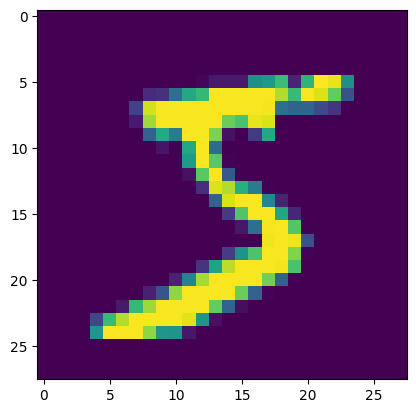

0


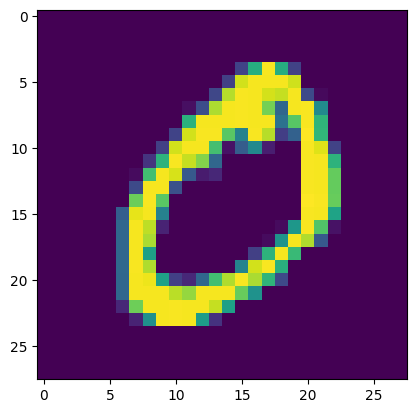

4


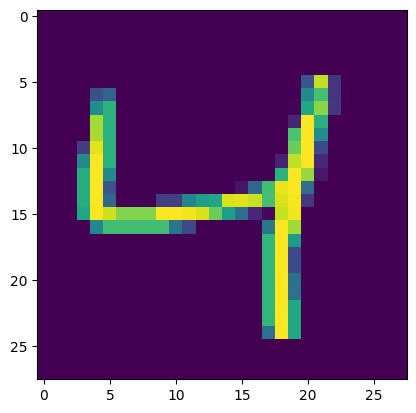

1


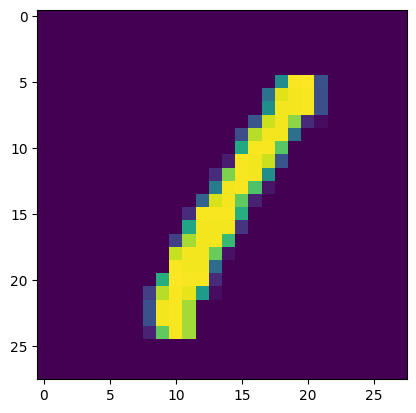

9


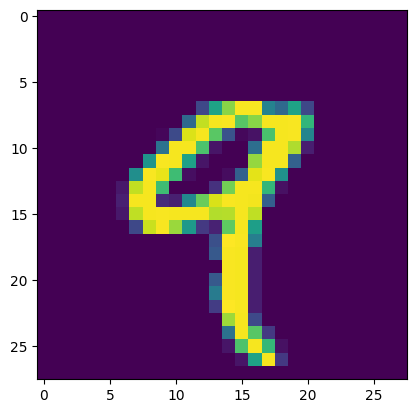

In [94]:
for i in range(5):
  example_i = train_loader.dataset[i][0].reshape(28,28)
  plt.imshow(example_i)
  print(train_loader.dataset[i][1])
  plt.show()

## **Define Metrics and Helper Functions**




### Accuracy evaluation

In [95]:
def acc_eval(preds, labels):
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Displaying the confusion matrix

In [96]:
"""
The confusion matrix displays the spectrum of predictions across each class,
which predictions were truly/falsly positive (this is a 7), and which ones
were truly/falsly negative (this is a number other than 7)
"""

def plot_cm(preds, labels):
  plt.figure(figsize=(10,6))
  cm = confusion_matrix(labels, preds)
  fx = sns.heatmap(cm, annot=True,
                   fmt=".2f", cmap="GnBu")
  fx.set_title('Confusion Matrix\n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  l = ['0','1','2','3','4','5','6','7','8','9']
  fx.xaxis.set_ticklabels(l)
  fx.yaxis.set_ticklabels(l)
  plt.show()


### Finding TP, FP, TN, and FN

In [97]:
# True positive: Predicted to be a number n, is actually that number n
# False positive: Predicted to be a number n, is actually NOT that number n
# True negative: Predicted to NOT be a number n, is actually NOT that number n
# False negative: Predicted to NOT be a number n, is actually that number n
def get_confusion_vals(preds, labels):
  cm = confusion_matrix(labels, preds)

  true_pos = np.diag(cm) # sums the diagonal of the cm
  false_pos = cm.sum(axis=0) - true_pos # cm.sum(axis=0) sums the cm rows
  false_neg = cm.sum(axis=1) - true_pos # cm.sum(axis=1) sums the cm cols

  true_neg = cm.sum() - (false_pos + false_neg + true_pos)

  return true_pos, false_pos, true_neg, false_neg

### Calculating recall, specificity, precision, and F1 score

In [98]:
"""
Each metric is in its own function in case it needs to be called later without
the use of the get_metrics function. It also helped me to seperate the formulas
visually. However you could totally do this without the extra functions.
"""

# Recall, or "true positive rate"
def get_recall(true_pos, false_neg):
  return true_pos / (true_pos + false_neg)

# Specificity, or "true negative rate"
def get_specificity(true_neg, false_pos):
  return true_neg / (true_neg + false_pos)

# Precision, or "positive predictive rate"
def get_precision(true_pos, false_pos):
  return true_pos / (true_pos + false_pos)

# F1 Score, measures a model's accuracy by combining precision and recall scores
def get_f1(precision, recall):
  return (2 * precision * recall) / (precision + recall)

# Calls other metric evaluation functions
def get_metrics(true_pos, false_pos, true_neg, false_neg):
  r = get_recall(true_pos, false_neg)
  s = get_specificity(true_neg, false_pos)
  p = get_precision(true_pos, false_pos)
  f1 = get_f1(p,r)

  return r, s, p, f1

### Printing net specific metrics

In [99]:
def show_metrics(preds, labels, save_means, net_label):
  acc = acc_eval(preds, labels)
  # plot_cm(preds, labels)
  tp, fp, tn, fn = get_confusion_vals(preds, labels)
  recall, specif, precis, f1 = get_metrics(tp, fp, tn, fn)
  print(f'\n\n-=-=-=-=-={net_label}=-=-=-=-=-')
  print('=====Conf. Matrix======')
  print(f'True positives: {tp}')
  print(f'False positives: {fp}')
  print(f'True negatives: {tn}')
  print(f'False negatives: {fn}')
  print('\n=====Eval. Metrics=====')
  print(f'Accuracy: {acc.item()*100:.4f}%')
  print('-------------')
  print(f'Class Specific Recall:\n\n{recall}')
  print(f'\nAverage Recall: {np.mean(recall)}')
  print('-------------')
  print(f'Class Specific Specificity:\n\n{specif}')
  print(f'\nAverage Specificity: {np.mean(specif)}')
  print('-------------')
  print(f'Class Specific Precision:\n\n{precis}')
  print(f'\nAverage Precison: {np.mean(precis)}')
  print('-------------')
  print(f'Class Specific F1 Score:\n\n{f1}')
  print(f'\nAverage F1 Score: {np.mean(f1)}')


  if save_means == 1:
    return [acc.item()*100, np.mean(recall),
            np.mean(specif), np.mean(precis),
            np.mean(f1)]

### Printing comparison metrics

In [100]:
def compare_metrics(means, total_params):
  print('\n=====Total Params=====')
  for i in range(len(total_params)): print(f'{total_params[i][0]}: {total_params[i][1]}')
  print('\n=====Accuracy=====')
  for i in range(len(means)): print(f'{means[i][0]}: {means[i][1][0]:.4f}')
  print('\n=====Recall=====')
  for i in range(len(means)): print(f'{means[i][0]}: {means[i][1][1]}')
  print('\n=====Specificity=====')
  for i in range(len(means)): print(f'{means[i][0]}: {means[i][1][2]}')
  print('\n=====Precision=====')
  for i in range(len(means)): print(f'{means[i][0]}: {means[i][1][3]}')
  print('\n=====F1 Score=====')
  for i in range(len(means)): print(f'{means[i][0]}: {means[i][1][4]}')

### Calculate total parameters

In [101]:
def count_parameters(model):
  # p.numel() sums all the combinations of parameters
  # p.numel([500,500]) yields 500^2 params
    return sum(p.numel() for p in model.parameters())

# **Model Generation**




## **Feed Forward NN**

### Set our hyper parameters

In [102]:
input_size = 784 # number of input nodes (each image is 28x28 px)
hidden_size = 706 # size of the hidden layer (between i/o)
hidden_num = 2 # number of hidden layers (between i/o)

### Create FFNeuralNet class utilizing Torch NN module

In [103]:
# fully connected neural network with one hidden layer
# implement functionality for finetuning hidden_size and hidden_layer_num
# hidden_size = number of nodes per layer
# hidden_num = number of layers in the ****hidden zone*****

class FFNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, hidden_num):
        """Python note: we use super().__init__() to inherit all
        values initialized in the parent (super) class. In this case
        there are probably a bunch of variables predefined in the Torch
        NN class that we need to access, but don't want to mess with."""
        super(FFNeuralNet, self).__init__()
        """We set the rest of the attributes to OUR hyper-params that we
        defined in [3]"""
        # here we init ReLU
        self.relu = nn.ReLU() # ReLU acivation function from torch
        self.input_size = input_size # here we specify the input size
        self.hidden_num = hidden_num # here we specify the num of hidden layers

        # Create our layers

        self.input_layer = nn.Linear(input_size, hidden_size) # first layer

        self.hidden_layers = nn.ModuleList() # list for remaining hidden layers

        for i in range(0, hidden_num): # create remaining layers
          self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, num_classes) # output layer

    """Here we define our feed forward method, we won't be using softmax at
    the moment, but we will be utilizing it later.

    Torch note: Every nn.Module subclass implements the operations in the
    forward method on the data."""
    def forward(self, x):
        # Utilize hidden layers and apply activation (ReLU)
        out = self.relu(self.input_layer(x)) # input layer

        for i in range(self.hidden_num): # hidden layers
          out = self.relu(self.hidden_layers[i](out))

        out = self.output_layer(out) # output layer
        return out


model = FFNeuralNet(input_size, hidden_size, num_classes, hidden_num).to(device)
criterion, optimizer = wipe_loss_and_optimizer(model)
ffnn_params = count_parameters(model)

### Create training loop


In [104]:
n_total_steps = len(train_loader) # get the total number of training instances

"""
Here we utilize a nested for loop since we need to iterate over epochs, and
train in batches inside of those epochs.
"""
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):

    """
    We need to reshape the training data since it comes packed in a tuple
    containing a matrix of pixel values and a target value, we want it to be a
    1D so we can feed the data into our net
    """
    images = images.reshape(-1, 28*28).to(device) # reshape the data
    labels = labels.to(device) # upload the labels to the device
    """
    Here we pass our image data arr[input_size] through the model and calculate
    the loss function.
    """
    outputs = model(images) # run the input data through our model
    loss = criterion(outputs, labels) # run the loss function (CLE)
    """
    Now that we have the output from our loss function, we preform stochastic
    (one at a time) gradient descent optimization using Adam. This updates our
    weights after every training instance.
    """
    optimizer.zero_grad() # initializes the gradient tensor to zero
    loss.backward() # back-prop and compute the gradient
    optimizer.step() # preform a single optimization step
    """
    To track our runtime progress we will print the loss function after every
    100th step and show our total steps.
    """
    if (i+1) % 100 == 0:
      print(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch[1/2], Step[100/600], Loss: 0.2773
Epoch[1/2], Step[200/600], Loss: 0.1657
Epoch[1/2], Step[300/600], Loss: 0.0840
Epoch[1/2], Step[400/600], Loss: 0.1160
Epoch[1/2], Step[500/600], Loss: 0.1363
Epoch[1/2], Step[600/600], Loss: 0.1879
Epoch[2/2], Step[100/600], Loss: 0.0775
Epoch[2/2], Step[200/600], Loss: 0.1282
Epoch[2/2], Step[300/600], Loss: 0.0862
Epoch[2/2], Step[400/600], Loss: 0.0354
Epoch[2/2], Step[500/600], Loss: 0.1216
Epoch[2/2], Step[600/600], Loss: 0.0723


### Create testing loop


In [105]:
model.eval() # puts the model in 'evaluation mode' blocking any updates

with torch.no_grad():
  ffnn_preds = torch.tensor([]).to(device) # loads an empty list of predictions to gpu
  ffnn_labels = torch.tensor([]).to(device) # loads an empty list of labesl to gpu

  for i, (image, label) in tqdm(enumerate(test_loader)):
    image = image.reshape(-1, 28*28).to(device) # reshape the images in to 1x28
    label = label.to(device)
    output = model(image) # get the probabilities

    output = F.softmax(output, dim=1) # softmax the output probs
    predicted = torch.max(output, dim=1)[1] # choose the highest probability

    # update our predictions and labels lists
    ffnn_preds = torch.cat((ffnn_preds, predicted), dim=0)
    ffnn_labels = torch.cat((ffnn_labels, label), dim=0)


  ffnn_preds = ffnn_preds.cpu().detach()
  ffnn_labels = ffnn_labels.cpu().detach()

100it [00:01, 70.39it/s]


##**Convolutional NN**

###Create ConvNeuralNet class utilizing Torch NN module

In [106]:
# hidden_size = number of nodes per layer
# hidden_num = number of layers in the ****hidden zone*****

class ConvNeuralNet(nn.Module):
    def __init__(self, channel_n1_size, channel_n2_size, num_classes):
        """Python note: we use super().__init__() to inherit all
        values initialized in the parent (super) class. In this case
        there are probably a bunch of variables predefined in the Torch
        NN class that we need to access, but don't want to mess with."""
        super(ConvNeuralNet, self).__init__()
        """We set the rest of the attributes to OUR hyper-params that we
        defined in [3]"""
        # here we init ReLU
        self.relu = nn.ReLU() # ReLU acivation function from torch
        self.input_size = input_size # here we specify the input size
        self.hidden_num = hidden_num # here we specify the num of hidden layers

        # Hyperparams for Convolutional and Pooling layers
        self.in_channels = 1
        self.kernel_size = 5
        self.n1 = channel_n1_size
        self.n2 = channel_n2_size

        # Define our pool
        self.pool = nn.MaxPool2d(2,2)
        self.cool_pool = nn.MaxPool2d(8,8)
        # First convolutional layer
        self.conv_layer_1 = nn.Conv2d(self.in_channels, self.n1, self.kernel_size)

        # Second convolutional layer
        self.conv_layer_2 = nn.Conv2d(self.n1, self.n2, self.kernel_size)

        # Fixed fully connected FF NN
        self.lin_input_layer = nn.Linear(self.n2, 500)
        self.lin_hidden_layer = nn.Linear(500, 125)
        self.lin_output_layer = nn.Linear(125, 10)

    """Here we define our feed forward method, we won't be using softmax at
    the moment, but we will be utilizing it later.

    Torch note: Every nn.Module subclass implements the operations in the
    forward method on the data."""
    def forward(self, x):
        # run the input through the convolutional network
        out = self.conv_layer_1(x)
        out = self.pool(out)
        out = self.conv_layer_2(out)
        out = self.cool_pool(out)

        # flatten the data to 1x1xn2
        out = torch.flatten(out, 1)

        # run out through fixed fully connected nn
        out = self.lin_input_layer(out)
        out = self.lin_hidden_layer(out)
        out = self.lin_output_layer(out)

        return out

model = ConvNeuralNet(69, 675, 10).to(device)
criterion, optimizer = wipe_loss_and_optimizer(model)
cnn_params = count_parameters(model)

###Create training Loop

In [107]:
n_total_steps = len(train_loader) # get the total number of training instances

"""
Here we utilize a nested for loop since we need to iterate over epochs, and
train in batches inside of those epochs.
"""
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(train_loader), total=n_total_steps)
    for i, (images, labels) in pbar:
        """
        We need to reshape the training data since it comes packed in a tuple
        containing a matrix of pixel values and a target value, we want it to be a
        1D so we can feed the data into our net
        """
        labels = labels.to(device) # upload the labels to the device
        images = images.to(device)
        """
        Here we pass our image data arr[input_size] through the model and calculate
        the loss function.
        """
        outputs = model(images) # run the input data through our model
        loss = criterion(outputs, labels) # run the loss function (CLE)
        """
        Now that we have the output from our loss function, we perform stochastic
        (one at a time) gradient descent optimization using Adam. This updates our
        weights after every training instance.
        """
        optimizer.zero_grad() # initializes the gradient tensor to zero
        loss.backward() # back-prop and compute the gradient
        optimizer.step() # perform a single optimization step

        """
        To track our runtime progress we will print the loss function after every
        100th step and show our total steps.
        """
        if (i+1) % 100 == 0:
            pbar.set_description(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch[2/2], Step[600/600], Loss: 0.1696: 100%|██████████| 600/600 [00:10<00:00, 59.29it/s]


### Create testing loop and save predictions

In [108]:
model.eval()
with torch.no_grad():
  cnn_preds = torch.tensor([]).to(device)
  cnn_labels = torch.tensor([]).to(device)

  for i, (image, label) in tqdm(enumerate(test_loader)):
    image = image.to(device)
    label = label.to(device)
    output = model(image)

    output = F.softmax(output, dim=1)
    predicted = torch.max(output, dim=1)[1]

    cnn_preds = torch.cat((cnn_preds, predicted), dim=0)
    cnn_labels = torch.cat((cnn_labels, label), dim=0)

  cnn_preds = cnn_preds.cpu().detach()
  cnn_labels = cnn_labels.cpu().detach()

100it [00:01, 72.31it/s]


##**Transformer NN**


### Set our model specific hyperparameters

In [109]:
num_layers = 1    # Define the number of layers in the encoder
hidden_dim = 256  # The number of hidden units in the transformer model
num_heads = 2   # The number of heads in the multiheadattention models

### Create TransNeuralNet class utilizing Torch NN module


In [110]:
class TransNeuralNet(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, hidden_dim, num_heads):
        super(TransNeuralNet, self).__init__()
        self.num_layers = num_layers
        # Layer to transform the input image into the expected shape for the transformer encoder
        self.pos_encoder = nn.Linear(input_size, hidden_dim)
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        # Decoder
        self.decoder = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = x.view(-1, input_size)  # Reshape the input tensor
        x = self.pos_encoder(x)
        x = x.unsqueeze(1)  # Add the sequence dimension
       # Transformer Encoder
        x = self.transformer_encoder(x)
        # Decoder
        x = self.decoder(x.squeeze(1))
        return x
# Initialize the model

model = TransNeuralNet(input_size, num_classes, num_layers, hidden_dim, num_heads).to(device)
criterion, optimizer = wipe_loss_and_optimizer(model)
tnn_params = count_parameters(model)


### Create training loop

In [111]:
n_total_steps = len(train_loader) # get the total number of training instances

"""
Here we utilize a nested for loop since we need to iterate over epochs, and
train in batches inside of those epochs.
"""
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(train_loader), total=n_total_steps)
    for i, (images, labels) in pbar:
        """
        We need to reshape the training data since it comes packed in a tuple
        containing a matrix of pixel values and a target value, we want it to be a
        1D so we can feed the data into our net
        """
        images = images.to(device) # upload the images to the device
        labels = labels.to(device) # upload the labels to the device
        """
        Here we pass our image data arr[input_size] through the model and calculate
        the loss function.
        """
        outputs = model(images) # run the input data through our model
        loss = criterion(outputs, labels) # run the loss function (CLE)
        """
        Now that we have the output from our loss function, we perform stochastic
        (one at a time) gradient descent optimization using Adam. This updates our
        weights after every training instance.
        """
        optimizer.zero_grad() # initializes the gradient tensor to zero
        loss.backward() # back-prop and compute the gradient
        optimizer.step() # perform a single optimization step

        """
        To track our runtime progress we will print the loss function after every
        100th step and show our total steps.
        """
        if (i+1) % 100 == 0:
            pbar.set_description(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch[2/2], Step[600/600], Loss: 0.0635: 100%|██████████| 600/600 [00:10<00:00, 55.37it/s]


### Create testing loop and save predictions

In [112]:
model.eval()
with torch.no_grad():
  tnn_preds = torch.tensor([]).to(device)
  tnn_labels = torch.tensor([]).to(device)

  for i, (image, label) in tqdm(enumerate(test_loader)):
    image = image.to(device)
    label = label.to(device)
    output = model(image)

    output = F.softmax(output, dim=1)
    predicted = torch.max(output, dim=1)[1]

    tnn_preds = torch.cat((tnn_preds, predicted), dim=0)
    tnn_labels = torch.cat((tnn_labels, label), dim=0)

  tnn_preds = tnn_preds.cpu().detach()
  tnn_labels = tnn_labels.cpu().detach()

100it [00:01, 68.88it/s]


# **Model Evaluation & Comparison**

### Feed Forward NN metrics

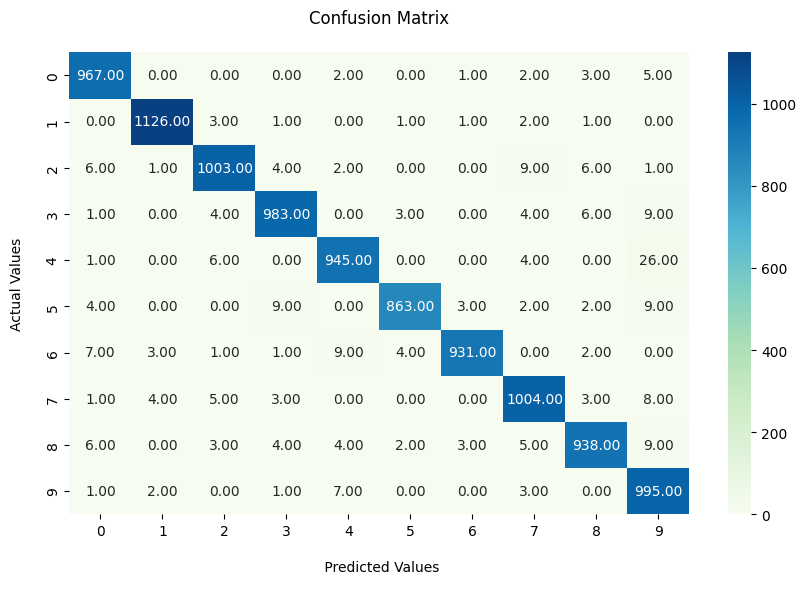



-=-=-=-=-=Feed Forward=-=-=-=-=-
=====Conf. Matrix======
True positives: [ 967 1126 1003  983  945  863  931 1004  938  995]
False positives: [27 10 22 23 24 10  8 31 23 67]
True negatives: [8993 8855 8946 8967 8994 9098 9034 8941 9003 8924]
False negatives: [13  9 29 27 37 29 27 24 36 14]

=====Eval. Metrics=====
Accuracy: 97.5500%
-------------
Class Specific Recall:

[0.98673469 0.99207048 0.97189922 0.97326733 0.96232179 0.96748879
 0.97181628 0.9766537  0.96303901 0.98612488]

Average Recall: 0.9751416182407864
-------------
Class Specific Specificity:

[0.99700665 0.99887197 0.99754683 0.9974416  0.99733866 0.99890206
 0.99911524 0.99654481 0.99745181 0.9925481 ]

Average Specificity: 0.9972767731012734
-------------
Class Specific Precision:

[0.97283702 0.99119718 0.97853659 0.97713718 0.9752322  0.98854525
 0.9914803  0.97004831 0.9760666  0.93691149]

Average Precison: 0.9757992104376969
-------------
Class Specific F1 Score:

[0.97973658 0.99163364 0.97520661 0.97519841 0.

In [113]:
plot_cm(ffnn_preds, ffnn_labels)
ffnn_means = show_metrics(ffnn_preds, ffnn_labels, 1, "Feed Forward")

### Convolutional NN metrics

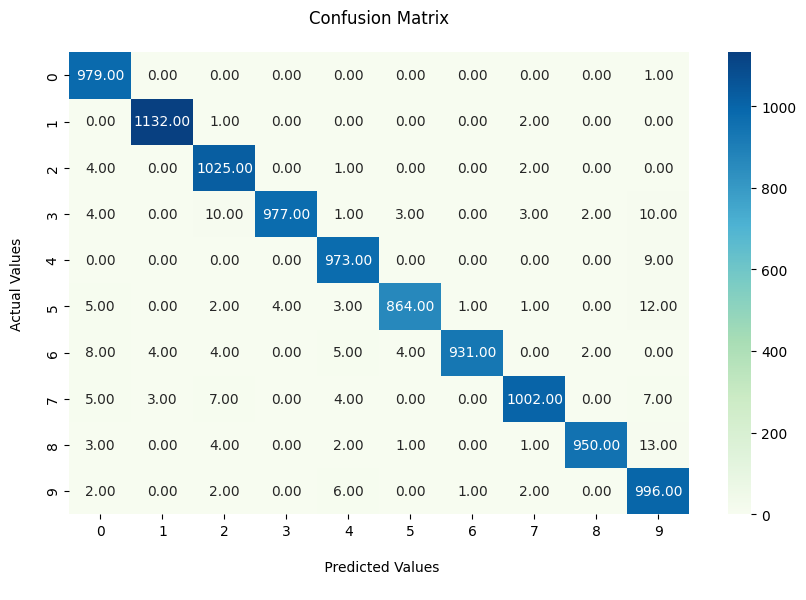



-=-=-=-=-=Convolutional=-=-=-=-=-
=====Conf. Matrix======
True positives: [ 979 1132 1025  977  973  864  931 1002  950  996]
False positives: [31  7 30  4 22  8  2 11  4 52]
True negatives: [8989 8858 8938 8986 8996 9100 9040 8961 9022 8939]
False negatives: [ 1  3  7 33  9 28 27 26 24 13]

=====Eval. Metrics=====
Accuracy: 98.2900%
-------------
Class Specific Recall:

[0.99897959 0.99735683 0.99321705 0.96732673 0.99083503 0.96860987
 0.97181628 0.97470817 0.97535934 0.98711596]

Average Recall: 0.98253248574275
-------------
Class Specific Specificity:

[0.99656319 0.99921038 0.99665477 0.99955506 0.99756043 0.99912165
 0.99977881 0.99877396 0.99955684 0.99421644]

Average Specificity: 0.9980991538388763
-------------
Class Specific Precision:

[0.96930693 0.99385426 0.97156398 0.99592253 0.97788945 0.99082569
 0.99785638 0.98914116 0.99580713 0.95038168]

Average Precison: 0.9832549182605449
-------------
Class Specific F1 Score:

[0.9839196  0.99560246 0.9822712  0.98141637 0.9

In [114]:
plot_cm(cnn_preds, cnn_labels)
cnn_means = show_metrics(cnn_preds, cnn_labels, 1, "Convolutional")

### Transformer NN metrics

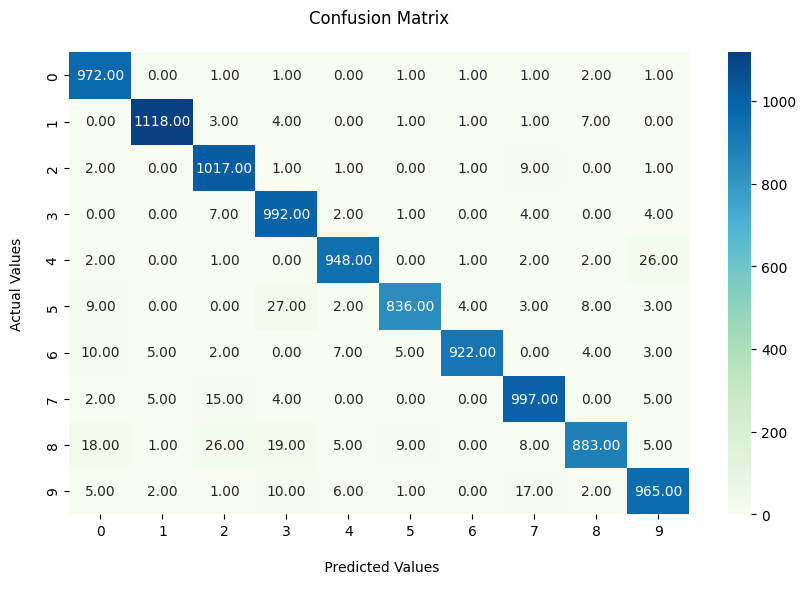



-=-=-=-=-=Transformer=-=-=-=-=-
=====Conf. Matrix======
True positives: [ 972 1118 1017  992  948  836  922  997  883  965]
False positives: [48 13 56 66 23 18  8 45 25 48]
True negatives: [8972 8852 8912 8924 8995 9090 9034 8927 9001 8943]
False negatives: [ 8 17 15 18 34 56 36 31 91 44]

=====Eval. Metrics=====
Accuracy: 96.5000%
-------------
Class Specific Recall:

[0.99183673 0.98502203 0.98546512 0.98217822 0.96537678 0.93721973
 0.96242171 0.96984436 0.90657084 0.95639247]

Average Recall: 0.9642327987800998
-------------
Class Specific Specificity:

[0.99467849 0.99853356 0.99375558 0.99265851 0.99744955 0.99802372
 0.99911524 0.9949844  0.99723022 0.99466133]

Average Specificity: 0.9961090584464032
-------------
Class Specific Precision:

[0.95294118 0.98850575 0.94780988 0.93761815 0.97631308 0.97892272
 0.99139785 0.95681382 0.97246696 0.95261599]

Average Precison: 0.9655405367311916
-------------
Class Specific F1 Score:

[0.972      0.98676081 0.96627078 0.95938104 0.9

In [115]:
plot_cm(tnn_preds, tnn_labels)
tnn_means = show_metrics(tnn_preds, tnn_labels, 1, "Transformer")

### Compare average metrics

In [116]:
means = (["FEED", ffnn_means],["CONV", cnn_means],["TRANS", tnn_means])
params = (["FEED", ffnn_params], ["CONV", cnn_params], ["TRANS", tnn_params])
compare_metrics(means, params)


=====Total Params=====
FEED: 1559564
CONV: 1568729
TRANS: 1518602

=====Accuracy=====
FEED: 97.5500
CONV: 98.2900
TRANS: 96.5000

=====Recall=====
FEED: 0.9751416182407864
CONV: 0.98253248574275
TRANS: 0.9642327987800998

=====Specificity=====
FEED: 0.9972767731012734
CONV: 0.9980991538388763
TRANS: 0.9961090584464032

=====Precision=====
FEED: 0.9757992104376969
CONV: 0.9832549182605449
TRANS: 0.9655405367311916

=====F1 Score=====
FEED: 0.9753700022130204
CONV: 0.9827534742174446
TRANS: 0.9645688060783311
